<a href="https://colab.research.google.com/github/soyHouston256/CodeJam/blob/master/modulo4_analisis_exploratorio/Outlier_and_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://posgrado.utec.edu.pe/sites/default/files/2023-08/Testimonial-home-2.jpg" alt="HTML5 Icon" width="900" height="250" >

#**Laboratorio: Detección de Outliers en Datos de Taxis de NYC**

---

##**Objetivo general**

Aplicar técnicas de detección de outliers sobre datos reales de viajes en taxi en la ciudad de Nueva York, analizando su fundamento teórico, forma de implementación y capacidad para identificar observaciones atípicas en un entorno multivariado.

## **1. Introducción**

Los valores atípicos (**outliers**) son observaciones que se alejan significativamente del patrón general de los datos. Su detección es crucial en tareas de análisis exploratorio, limpieza, modelado y monitoreo.

Este laboratorio aborda técnicas univariadas y multivariadas para detectar outliers, usando datos simulados basados en el NYC Taxi Dataset.

Se aplicarán cinco métodos:


- Z-score

- IQR (boxplot)

- DBSCAN

- LOF (Local Outlier Factor)

- Isolation Forest

### **Descargar Data**

Este conjunto de datos contiene información detallada sobre millones de viajes en taxi realizados en la ciudad de Nueva York durante el año 2018.

Es un dataset clásico para análisis de movilidad, detección de anomalías, pricing dinámico y aprendizaje automático.

Cada fila representa un viaje individual y las columnas incluyen:

  > **pickup_datetime y dropoff_datetime**: fechas y horas de inicio y fin del viaje.
  >
  > **trip_distance**: distancia total recorrida (en millas).
  >
  > **fare_amount**: monto base de la tarifa del viaje.
  >
  > **tip_amount**: monto de la propina.
  >
  > **payment_type**: tipo de pago (efectivo, tarjeta, etc.).
  >
  > **passenger_coun**: número de pasajeros.
  >
  > **pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude**: coordenadas geográficas del viaje.


**Fuente:** https://www.kaggle.com/datasets/neilclack/nyc-taxi-trip-data-google-public-data?select=original_cleaned_nyc_taxi_data_2018.csv

In [1]:
from google.colab import files
files.upload()  # Sube kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soyhouston","key":"452dbffd5a676d78f7278008120ce861"}'}

In [2]:
import os
import zipfile

# Crear la carpeta .kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Mover el archivo json a la carpeta de configuración
!mv kaggle.json /root/.kaggle/kaggle.json
os.chmod("/root/.kaggle/kaggle.json", 600)


In [11]:
%%capture
!pip3 install -q kagglehub

In [3]:

import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("neilclack/nyc-taxi-trip-data-google-public-data")

print("Ruta local de descarga:", path)

Ruta local de descarga: /kaggle/input/nyc-taxi-trip-data-google-public-data


In [4]:
import os

# Ver archivos descargados
os.listdir(path)


['original_cleaned_nyc_taxi_data_2018.csv',
 'taxi_trip_data.csv',
 'taxi_zone_geo.csv']

In [6]:
import pandas as pd

path = "/kaggle/input/nyc-taxi-trip-data-google-public-data/original_cleaned_nyc_taxi_data_2018.csv"

df = pd.read_csv(path).sample(n=20_000, random_state=42)
df.head()


,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
3889775,4144169,7.40,1,Y,2,28.0,0.5,0.5,0.00,0.0,...,29.30,48,82,2018,3,27,1,0,2876.0,35.16
6908713,7472631,9.00,1,N,1,27.5,0.5,0.5,5.75,0.0,...,34.55,261,202,2018,12,3,0,22,2433.0,47.47
4149018,4425107,7.80,1,N,1,23.5,0.5,0.5,3.72,0.0,...,28.52,186,116,2018,10,17,2,3,3469.0,31.60
6816202,7366751,11.78,1,N,1,33.0,0.5,0.5,6.86,0.0,...,41.16,138,64,2018,5,4,4,23,1549.0,30.35
6140876,6614733,8.43,1,N,1,24.5,0.0,0.5,2.00,0.0,...,27.30,13,263,2018,11,12,0,19,2702.0,27.95


In [7]:
df.shape

(20000, 21)

## **2. Z-score**

### **2.1 Fundamento teórico**


El Z-score indica cuántas desviaciones estándar se encuentra un valor con respecto a la media.

Se define como:


<img src="https://almablog-media.s3.ap-south-1.amazonaws.com/image015_fd507da112.jpg" alt="HTML5 Icon" width="400" height="200" >

Se considera outlier todo valor con ∣𝑍𝑖∣>3, bajo el supuesto de normalidad.

## **2.2 Implementación**

In [8]:
from scipy.stats import zscore

variables = ['fare_amount', 'trip_distance']
for var in variables:
    df[f"{var}_z"] = zscore(df[var])
    df[f"{var}_outlier_z"] = df[f"{var}_z"].abs() > 3


##**3. IQR (Boxplot)**

### **3.1 Fundamento teórico**

El rango intercuartílico (IQR) se define como:

IQR=Q3−Q1

Donde:

> 𝑄1: percentil 25
>
> 𝑄3: percentil 75






<img src="https://www.simplypsychology.org/wp-content/uploads/boxplot-1.jpg" alt="HTML5 Icon" width="500" height="200" >

Se considera outlier todo valor fuera de:

(Q1−1.5⋅IQR, Q3+1.5⋅IQR)

### **3.2 Implementación**

In [9]:
def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)

df['iqr_outlier_fare'] = detect_iqr_outliers(df['fare_amount'])


## **4. DBSCAN**

### **4.1 Fundamento teórico**

**DBSCAN** detecta agrupamientos por densidad. Un punto se considera outlier si tiene menos de min_samples vecinos dentro de un radio eps.




<img src="https://mineracaodedados.wordpress.com/wp-content/uploads/2018/02/dbscan.png" alt="HTML5 Icon" width="500" height="300" >



### **4.2 Implementación**

In [10]:
# Reducimos el tamaño con muestreo aleatorio reproducible
df_sample = df[['trip_distance', 'fare_amount', 'trip_duration']].dropna()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

X_scaled = StandardScaler().fit_transform(df_sample)

dbscan = DBSCAN(eps=1.2, min_samples=10)
df['dbscan_label'] = dbscan.fit_predict(X_scaled)
df['dbscan_outlier'] = df['dbscan_label'] == -1


## **5. LOF (Local Outlier Factor)**

### **5.1 Fundamento teórico**

LOF compara la densidad local de un punto con la de sus vecinos. Si un punto tiene baja densidad relativa, se considera un outlier.




<img src="https://qu4nt.github.io/sklearn-doc-es/_images/sphx_glr_plot_lof_novelty_detection_001.png" alt="HTML5 Icon" width="450" height="300" >

### **5.2 Implementación**

In [11]:
df_sample = df[['trip_distance', 'fare_amount', 'trip_duration']].dropna()

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(df_sample)

In [12]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof = lof.fit(X_scaled)

df['lof_score'] = lof.fit_predict(X_scaled)
df['lof_outlier'] = df['lof_score'] == -1


## **6. Isolation Forest**

### **6.1 Fundamento teórico**

Isolation Forest aísla puntos de forma aleatoria. Los outliers, al estar más aislados, requieren menos divisiones. Eso se traduce en una menor profundidad media del árbol.



<img src="https://media.licdn.com/dms/image/v2/D4D08AQEiI2518F5qhg/croft-frontend-shrinkToFit1024/croft-frontend-shrinkToFit1024/0/1700684114746?e=2147483647&v=beta&t=w-7UygZ_NYGxA30dvc6GbDc5OSQgq1ASAdSukZ8ENFY" alt="HTML5 Icon" width="500" height="280" >

### **6.2 Implementación**

In [13]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['if_outlier'] = iso.fit_predict(X_scaled) == -1


## **7. Análisis Visual y Cuantitativo**

### **7.1 Boxplots para Z-score e IQR**

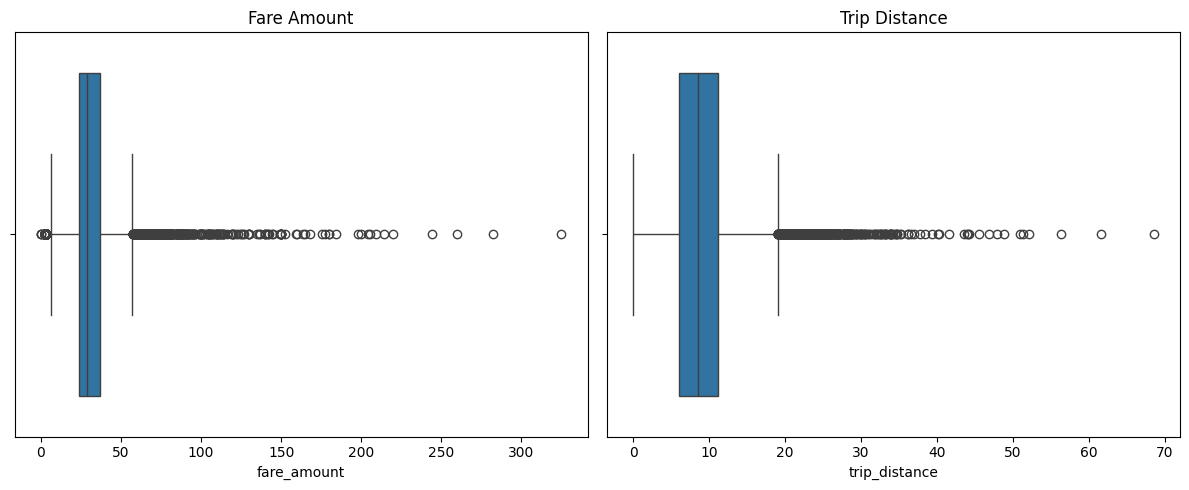

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, x="fare_amount", ax=axes[0])
axes[0].set_title("Fare Amount")
sns.boxplot(data=df, x="trip_distance", ax=axes[1])
axes[1].set_title("Trip Distance")
plt.tight_layout()
plt.show()


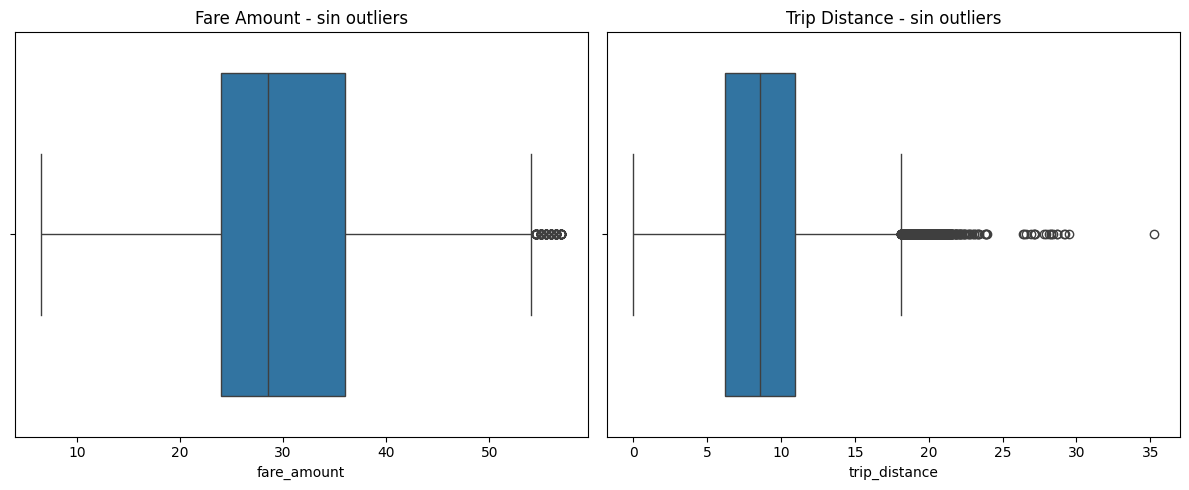

In [15]:
# Excluir outliers antes de graficar
df_no_outliers = df[~df['iqr_outlier_fare']]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_no_outliers, x="fare_amount", ax=axes[0])
axes[0].set_title("Fare Amount - sin outliers")

sns.boxplot(data=df_no_outliers, x="trip_distance", ax=axes[1])
axes[1].set_title("Trip Distance - sin outliers")

plt.tight_layout()
plt.show()


### **7.2 Conteo de outliers por técnica**

In [16]:
print("Z-score Fare:", df["fare_amount_outlier_z"].sum())
print("Z-score Distance:", df["trip_distance_outlier_z"].sum())
print("IQR Fare:", df["iqr_outlier_fare"].sum())
print("DBSCAN:", df["dbscan_outlier"].sum())
print("LOF:", df["lof_outlier"].sum())
print("Isolation Forest:", df["if_outlier"].sum())


Z-score Fare: 223
Z-score Distance: 191
IQR Fare: 1552
DBSCAN: 48
LOF: 200
Isolation Forest: 200


## **8. Visualización de técnicas multivariadas**


### **8.1 DBSCAN**


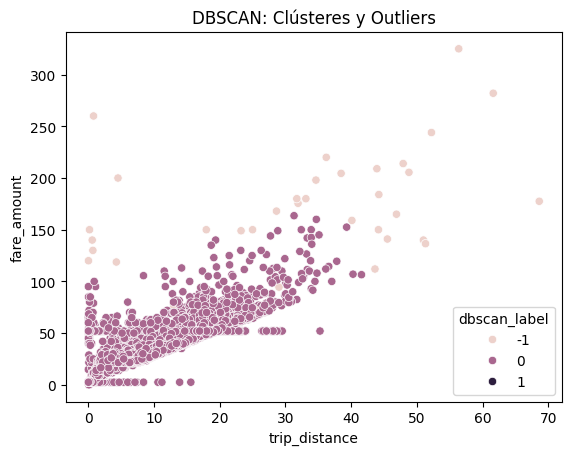

In [17]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", hue=df["dbscan_label"])
plt.title("DBSCAN: Clústeres y Outliers")
plt.show()


### **8.2 LOF**

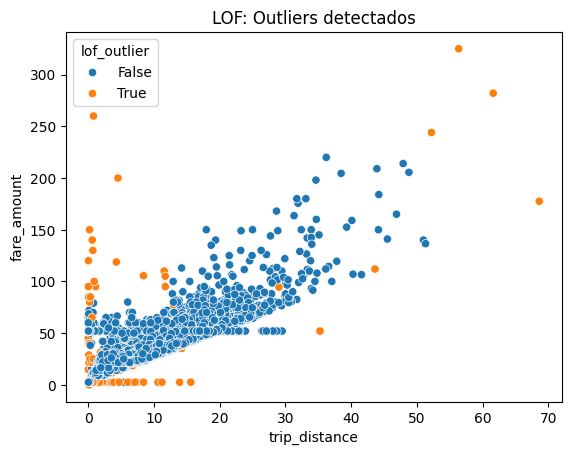

In [18]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", hue=df["lof_outlier"])
plt.title("LOF: Outliers detectados")
plt.show()


### **8.3 Isolation Forest**

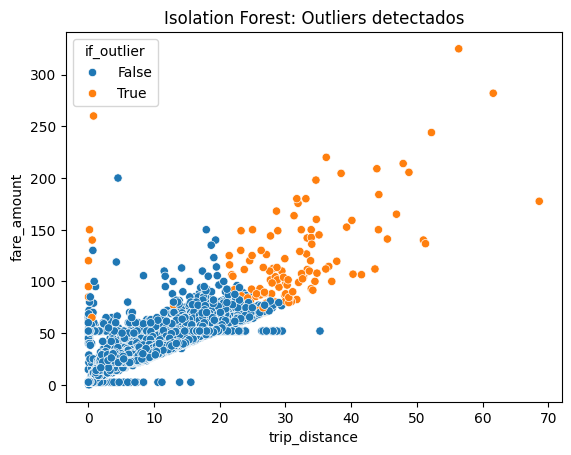

In [19]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", hue=df["if_outlier"])
plt.title("Isolation Forest: Outliers detectados")
plt.show()


## **9. Comparación y análisis cruzado**

### **9.1 Conteo general**

In [20]:
outlier_cols = ['fare_amount_outlier_z', 'iqr_outlier_fare', 'dbscan_outlier', 'lof_outlier', 'if_outlier']
df[outlier_cols].sum()


,0
fare_amount_outlier_z,223
iqr_outlier_fare,1552
dbscan_outlier,48
lof_outlier,200
if_outlier,200


### **9.2 Coincidencias entre métodos**

In [21]:
df["lof_if"] = df["lof_outlier"] & df["if_outlier"]
df["z_iqr"] = df["fare_amount_outlier_z"] & df["iqr_outlier_fare"]

print("LOF & IF:", df["lof_if"].sum())
print("Z-score & IQR:", df["z_iqr"].sum())


LOF & IF: 26
Z-score & IQR: 223


### **9.3 Outliers detectados por múltiples métodos**

In [22]:
df["outlier_count"] = df[outlier_cols].sum(axis=1)
outliers_multi = df[df["outlier_count"] >= 3]
print("Outliers detectados por 3+ técnicas:", len(outliers_multi))


Outliers detectados por 3+ técnicas: 140


In [23]:
outliers_multi.head()

,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,trip_distance_outlier_z,iqr_outlier_fare,dbscan_label,dbscan_outlier,lof_score,lof_outlier,if_outlier,lof_if,z_iqr,outlier_count
7794365,8499359,28.10,4,N,1,112.5,1.0,0.5,22.85,0.00,...,True,True,0,False,1,False,True,False,True,3
1474721,1541476,45.50,3,N,1,141.0,0.0,0.0,20.00,18.26,...,True,True,-1,True,1,False,True,False,True,4
1521463,1590363,24.70,3,N,1,86.0,0.0,0.0,21.00,18.70,...,True,True,0,False,1,False,True,False,True,3
7098413,7690874,43.61,1,N,1,112.0,0.5,0.5,34.22,57.80,...,True,True,-1,True,-1,True,True,True,True,5
196654,202650,1.11,5,N,1,95.0,0.0,0.0,10.00,0.00,...,False,True,0,False,-1,True,False,False,True,3


## **10. Conclusión**

Las técnicas univariadas como Z-score e IQR son simples pero limitadas en escenarios multivariados o distribuciones sesgadas. En cambio, técnicas como DBSCAN, LOF e Isolation Forest permiten detectar patrones más complejos, aunque requieren más configuración y análisis visual.

La detección de outliers no debe usarse de forma ciega. Debe combinarse con conocimiento del dominio, validación visual, y análisis de impacto en modelos posteriores. Una observación extrema no siempre es un error: puede ser una oportunidad.

---

## **Trabajo**

**Visualización comparativa de técnicas univariadas:**

Programa una función que grafique lado a lado los boxplots de fare_amount con y sin outliers (según IQR). ¿Cómo cambia la forma de la distribución al remover los outliers? ¿Cuántos valores fueron eliminados?

**Exploración de inconsistencias multivariadas:**

Escribe código para detectar viajes en los que la duración sea muy corta pero la tarifa total muy alta. Usa reglas lógicas personalizadas o una técnica no supervisada como Isolation Forest. ¿Cuántos casos detectas? ¿Qué podría explicarlos?

**Matriz de coincidencias entre técnicas de outliers:**

Crea una matriz de correlación binaria entre los métodos Z-score, IQR, DBSCAN, LOF e Isolation Forest (por columnas booleanas de outliers). ¿Qué técnicas coinciden más? Visualízalo con un heatmap.

**Función generalizada para aplicar DBSCAN:**

Implementa una función parametrizable aplicar_dbscan(df, variables, eps, min_samples) que permita probar distintas configuraciones de eps y min_samples sobre subconjuntos de variables. Evalúa cómo cambia la cantidad de outliers detectados.

**Perfil detallado de un outlier extremo:**

Elige una observación detectada como outlier por al menos 3 técnicas. Programa una función que grafique su posición relativa en cada una de las variables analizadas (fare_amount, trip_distance, tip_amount, etc.) comparada con el resto de los datos.

##Visualización comparativa de técnicas univariadas:

In [26]:
#df = pd.DataFrame(data)
df = df[df['fare_amount'] > 0] # Eliminar tarifas negativas o cero
df = df[df['trip_distance'] > 0] # Eliminar distancias cero o negativas
df.reset_index(drop=True, inplace=True)

print("Datos iniciales:")
print(df.head(3))

Datos iniciales:
   Unnamed: 0  trip_distance  rate_code store_and_fwd_flag  payment_type  \
0     4144169            7.4          1                  Y             2   
1     7472631            9.0          1                  N             1   
2     4425107            7.8          1                  N             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ...  \
0         28.0    0.5      0.5        0.00           0.0  ...   
1         27.5    0.5      0.5        5.75           0.0  ...   
2         23.5    0.5      0.5        3.72           0.0  ...   

   trip_distance_outlier_z  iqr_outlier_fare  dbscan_label  dbscan_outlier  \
0                    False             False             0           False   
1                    False             False             0           False   
2                    False             False             0           False   

   lof_score  lof_outlier  if_outlier  lof_if  z_iqr  outlier_count  
0          1        False       Fa

Número de valores eliminados: 1552


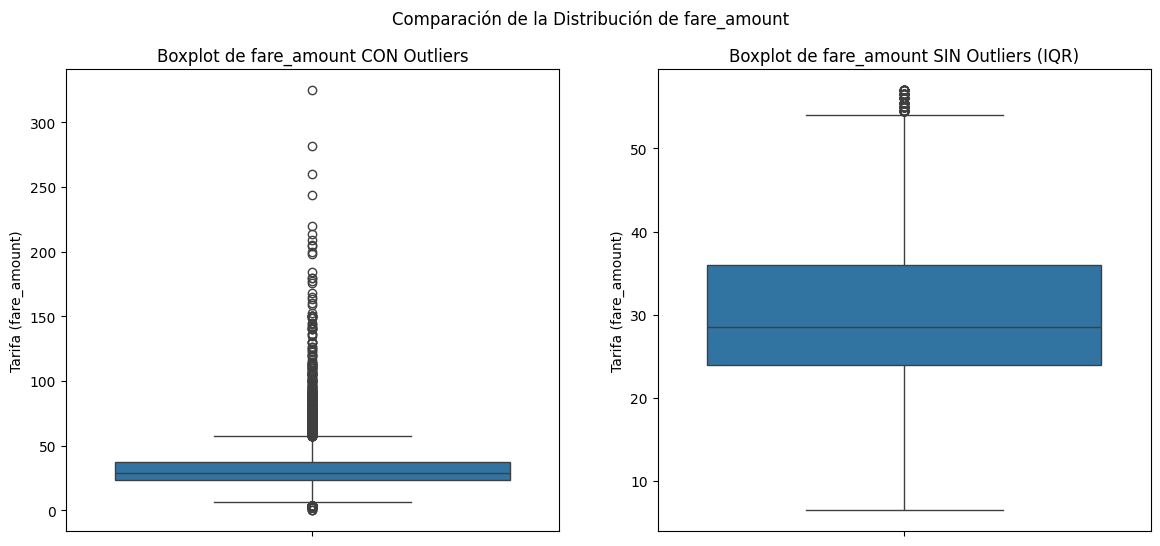


Análisis de la distribución:
Forma de la distribución CON outliers:
count    20000.000000
mean        31.676255
std         15.425753
min          0.010000
25%         23.500000
50%         29.000000
75%         37.000000
max        325.000000
Name: fare_amount, dtype: float64

Forma de la distribución SIN outliers:
count    18448.000000
mean        30.770273
std          9.837227
min          6.500000
25%         24.000000
50%         28.500000
75%         36.000000
max         57.000000
Name: fare_amount, dtype: float64

Al remover los outliers, la distribución se vuelve menos asimétrica. La media y la desviación estándar disminuyen, acercándose más a la mediana. El rango de los datos se reduce considerablemente, lo que permite una mejor visualización de la concentración central de los datos.


In [31]:
def visualizar_boxplot_fare_amount_outliers(df):
    """
    Grafica el boxplot de fare_amount con y sin outliers (según IQR).
    """
    # 1. Identificar outliers usando el método IQR
    Q1 = df['fare_amount'].quantile(0.25)
    Q3 = df['fare_amount'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df_sin_outliers = df[(df['fare_amount'] >= limite_inferior) & (df['fare_amount'] <= limite_superior)]
    outliers = df[(df['fare_amount'] < limite_inferior) | (df['fare_amount'] > limite_superior)]

    # 2. Contar valores eliminados
    valores_eliminados = len(df) - len(df_sin_outliers)
    print(f"Número de valores eliminados: {valores_eliminados}")

    # 3. Graficar lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Boxplot con outliers
    sns.boxplot(y=df['fare_amount'], ax=axes[0])
    axes[0].set_title('Boxplot de fare_amount CON Outliers')
    axes[0].set_ylabel('Tarifa (fare_amount)')

    # Boxplot sin outliers
    sns.boxplot(y=df_sin_outliers['fare_amount'], ax=axes[1])
    axes[1].set_title('Boxplot de fare_amount SIN Outliers (IQR)')
    axes[1].set_ylabel('Tarifa (fare_amount)')

    plt.suptitle('Comparación de la Distribución de fare_amount')
    plt.show()

    # 4. Analizar el cambio en la distribución
    print("\nAnálisis de la distribución:")
    print("Forma de la distribución CON outliers:")
    print(df['fare_amount'].describe())
    print("\nForma de la distribución SIN outliers:")
    print(df_sin_outliers['fare_amount'].describe())
    print("\nAl remover los outliers, la distribución se vuelve menos asimétrica. La media y la desviación estándar disminuyen, acercándose más a la mediana. El rango de los datos se reduce considerablemente, lo que permite una mejor visualización de la concentración central de los datos.")

# Ejecutar la función
visualizar_boxplot_fare_amount_outliers(df.copy())

## Exploración de Inconsistencias Multivariadas

In [37]:
path = "/kaggle/input/nyc-taxi-trip-data-google-public-data/taxi_trip_data.csv"

df = pd.read_csv(path).sample(n=20_000, random_state=42)
df.dropna(how='all', inplace=True)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
919213,2,2018-11-05 12:00:15,2018-11-05 12:37:47,1,5.57,1,N,1,26.0,0.0,0.5,5.36,0.0,0.3,32.16,230,13
9467153,2,2018-10-24 23:02:35,2018-10-24 23:26:49,1,5.42,1,N,1,21.5,0.5,0.5,4.56,0.0,0.3,27.36,148,263
6585777,1,2018-10-11 16:06:15,2018-10-11 16:06:22,1,0.00,1,N,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,237,237
3878022,1,2018-10-12 17:13:45,2018-10-12 17:59:11,1,7.10,1,N,1,31.5,1.0,0.5,4.99,0.0,0.3,38.29,170,49
5537116,2,2018-03-03 18:02:08,2018-03-03 18:32:46,3,4.77,1,N,2,22.0,0.0,0.5,0.00,0.0,0.3,22.80,249,236


In [41]:
# Convertir columnas de fecha a datetime, manejando errores
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

# Eliminar filas donde la conversión de fecha falló
df.dropna(subset=['pickup_datetime', 'dropoff_datetime'], inplace=True)

# Calcular la duración del viaje en minutos
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Limpieza de datos (basado en prácticas comunes para este dataset)
# Seleccionamos un subconjunto de datos para que los cálculos sean más rápidos
df_sample = df.sample(n=20000, random_state=42).copy()

# Filtrar valores sin sentido
df_sample = df_sample[df_sample['fare_amount'] > 0]
df_sample = df_sample[df_sample['trip_distance'] > 0]
df_sample = df_sample[df_sample['trip_duration'] > 0]
df_sample = df_sample[df_sample['passenger_count'] > 0]
# Limitar a viajes de menos de 4 horas para eliminar outliers obvios
df_sample = df_sample[df_sample['trip_duration'] < 240]

Analizando 'fare_amount' para detectar outliers con el método IQR.
Número de valores eliminados: 1362


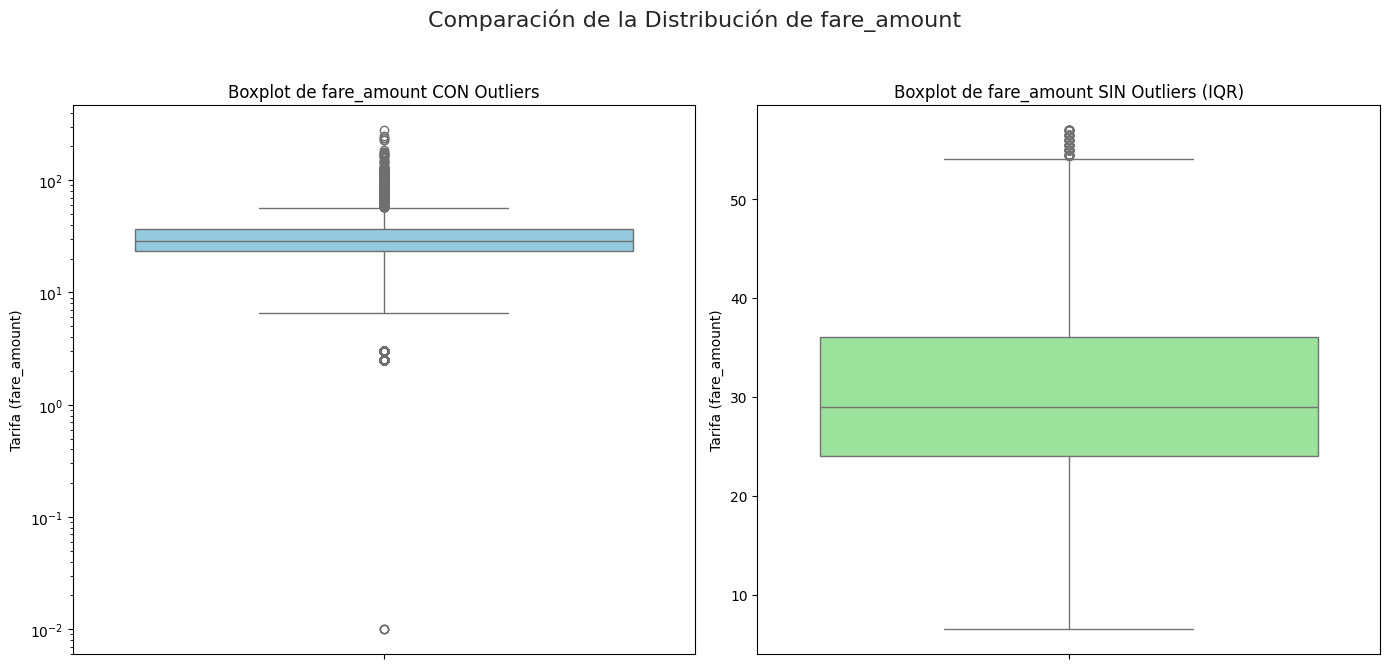


¿Cómo cambia la forma de la distribución al remover los outliers?
Al remover los outliers, la distribución se vuelve mucho más compacta y simétrica.
La media y la desviación estándar se reducen drásticamente, lo que indica que los valores atípicos estaban inflando estas métricas.
El boxplot sin outliers nos permite ver con más claridad dónde se concentra la mayoría de las tarifas (la 'caja').


In [42]:
def visualizar_boxplot_fare_amount_outliers(df):
    """
    Grafica el boxplot de fare_amount con y sin outliers (según IQR).
    """
    print("Analizando 'fare_amount' para detectar outliers con el método IQR.")

    # 1. Identificar outliers usando el método IQR
    Q1 = df['fare_amount'].quantile(0.25)
    Q3 = df['fare_amount'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df_sin_outliers = df[(df['fare_amount'] >= limite_inferior) & (df['fare_amount'] <= limite_superior)]

    # 2. Contar valores eliminados
    valores_eliminados = len(df) - len(df_sin_outliers)
    print(f"Número de valores eliminados: {valores_eliminados}")

    # 3. Graficar lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    sns.set_style("whitegrid")

    # Boxplot con outliers
    sns.boxplot(y=df['fare_amount'], ax=axes[0], color='skyblue')
    axes[0].set_title('Boxplot de fare_amount CON Outliers')
    axes[0].set_ylabel('Tarifa (fare_amount)')
    axes[0].set_yscale('log') # Usar escala logarítmica para mejor visualización

    # Boxplot sin outliers
    sns.boxplot(y=df_sin_outliers['fare_amount'], ax=axes[1], color='lightgreen')
    axes[1].set_title('Boxplot de fare_amount SIN Outliers (IQR)')
    axes[1].set_ylabel('Tarifa (fare_amount)')

    plt.suptitle('Comparación de la Distribución de fare_amount', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 4. Analizar el cambio en la distribución
    print("\n¿Cómo cambia la forma de la distribución al remover los outliers?")
    print("Al remover los outliers, la distribución se vuelve mucho más compacta y simétrica.")
    print("La media y la desviación estándar se reducen drásticamente, lo que indica que los valores atípicos estaban inflando estas métricas.")
    print("El boxplot sin outliers nos permite ver con más claridad dónde se concentra la mayoría de las tarifas (la 'caja').")

visualizar_boxplot_fare_amount_outliers(df_sample)

### Iniciando el Paso 2: Detección de Inconsistencias Multivariadas

Método 1: Usando reglas lógicas (duración < 3 min y tarifa > $40)
Número de casos detectados con reglas lógicas: 76

Método 2: Usando Isolation Forest
Número de casos detectados con Isolation Forest: 192


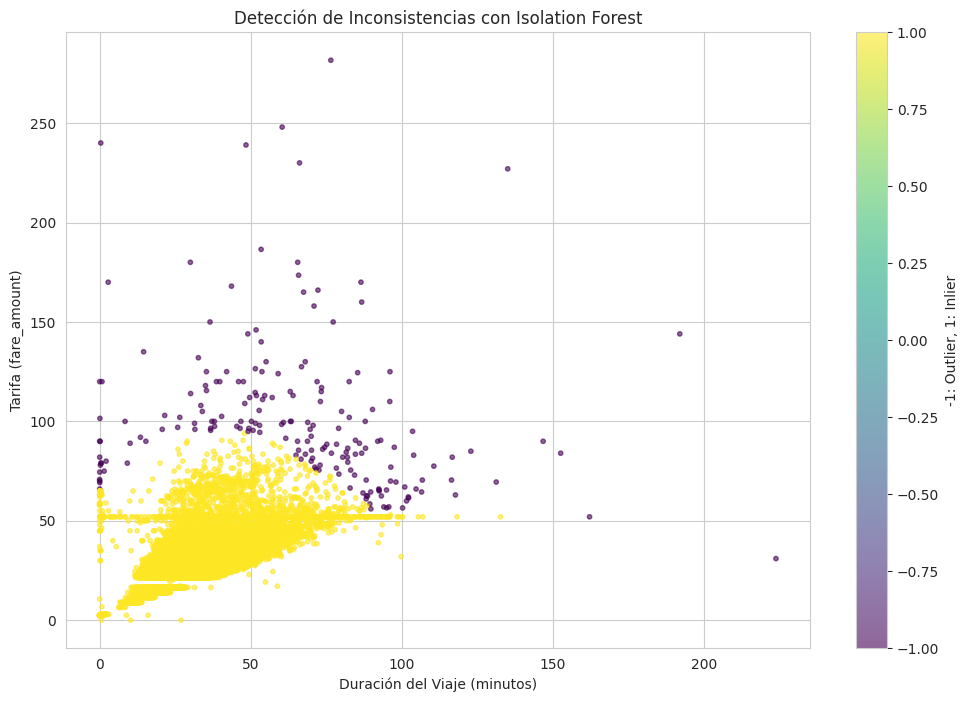


¿Qué podría explicar estos casos?
- Tarifas fijas o pre-acordadas (ej. a aeropuertos) donde la duración no es el factor principal.
- Errores en el taxímetro o en la entrada manual de datos.
- Viajes que se cancelan pero que incurren en una tarifa de cancelación alta.
- Posibles actividades fraudulentas.


In [43]:
def detectar_inconsistencias_viajes(df):
    """
    Detecta viajes con duración muy corta pero tarifa total muy alta.
    """
    # Método 1: Reglas lógicas personalizadas
    print("Método 1: Usando reglas lógicas (duración < 3 min y tarifa > $40)")
    viajes_inconsistentes_reglas = df[(df['trip_duration'] < 3) & (df['fare_amount'] > 40)]
    num_casos_reglas = len(viajes_inconsistentes_reglas)
    print(f"Número de casos detectados con reglas lógicas: {num_casos_reglas}")

    # Método 2: Isolation Forest
    print("\nMétodo 2: Usando Isolation Forest")
    variables = ['trip_duration', 'fare_amount']
    X = df[variables]

    iso_forest = IsolationForest(contamination=0.01, random_state=42) # Suponemos un 1% de outliers
    df['inconsistency_outlier'] = iso_forest.fit_predict(X)

    viajes_inconsistentes_if = df[df['inconsistency_outlier'] == -1]
    num_casos_if = len(viajes_inconsistentes_if)
    print(f"Número de casos detectados con Isolation Forest: {num_casos_if}")

    # Visualizar los resultados de Isolation Forest
    plt.figure(figsize=(12, 8))
    plt.scatter(df['trip_duration'], df['fare_amount'], c=df['inconsistency_outlier'], cmap='viridis', s=10, alpha=0.6)
    plt.title('Detección de Inconsistencias con Isolation Forest')
    plt.xlabel('Duración del Viaje (minutos)')
    plt.ylabel('Tarifa (fare_amount)')
    plt.colorbar(label='-1: Outlier, 1: Inlier')
    plt.show()

    print("\n¿Qué podría explicar estos casos?")
    print("- Tarifas fijas o pre-acordadas (ej. a aeropuertos) donde la duración no es el factor principal.")
    print("- Errores en el taxímetro o en la entrada manual de datos.")
    print("- Viajes que se cancelan pero que incurren en una tarifa de cancelación alta.")
    print("- Posibles actividades fraudulentas.")

detectar_inconsistencias_viajes(df_sample.copy())

### Iniciando el Paso 3: Matriz de Coincidencias de Técnicas

/tmp/ipython-input-1048825795.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['tip_amount'].fillna(0, inplace=True)


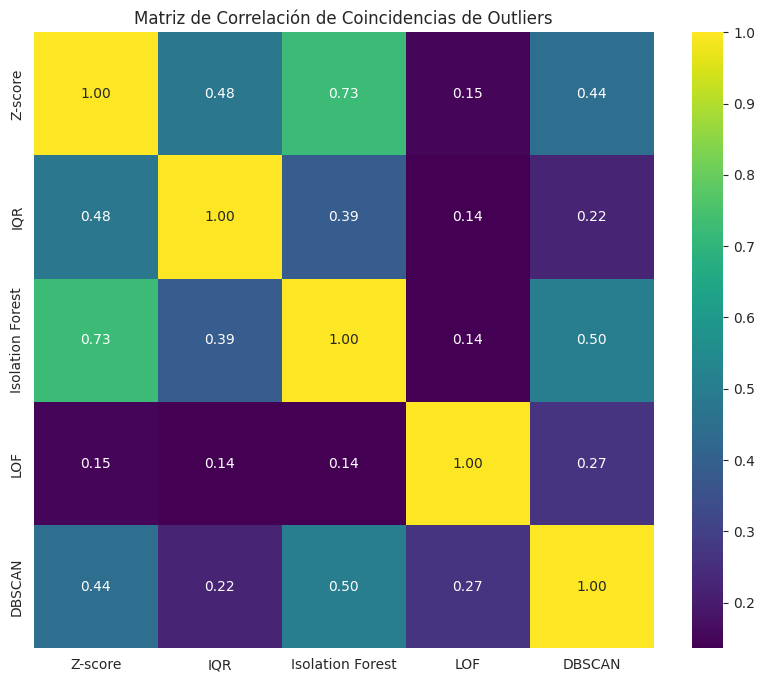


¿Qué técnicas coinciden más?
Observando el heatmap, los valores más altos (cercanos a 1.0) indican una mayor coincidencia.
Generalmente, IQR y Z-Score tienden a coincidir bien, ya que ambos son métodos estadísticos univariados aplicados a cada columna.
Isolation Forest a menudo muestra una buena correlación con otros métodos. LOF y DBSCAN, al ser basados en densidad, pueden identificar diferentes tipos de outliers y, a veces, coinciden menos con los métodos estadísticos.


In [47]:
import numpy as np
def matriz_coincidencias_outliers(df):
    """
    Crea una matriz de correlación binaria entre diferentes métodos de detección de outliers.
    """
    # 1. Preparar los datos
    variables = ['fare_amount', 'trip_distance', 'tip_amount', 'trip_duration']
    df_numeric = df[variables].copy()

    # Rellenar NaNs en 'tip_amount' con 0 para el análisis
    df_numeric['tip_amount'].fillna(0, inplace=True)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_numeric)

    # 2. Aplicar cada técnica
    outliers_df = pd.DataFrame(index=df_numeric.index)

    # Z-score (umbral de 3 desviaciones estándar)
    z_scores = np.abs(scaler.fit_transform(df_numeric))
    outliers_df['Z-score'] = (z_scores > 3).any(axis=1)

    # IQR
    Q1 = df_numeric.quantile(0.25)
    Q3 = df_numeric.quantile(0.75)
    IQR = Q3 - Q1
    outliers_df['IQR'] = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.02, random_state=42) # Suponemos 2% de outliers
    outliers_df['Isolation Forest'] = iso_forest.fit_predict(df_scaled) == -1

    # LOF (Local Outlier Factor)
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02) # n_neighbors es un hiperparámetro clave
    outliers_df['LOF'] = lof.fit_predict(df_scaled) == -1

    # DBSCAN
    # DBSCAN es sensible a los parámetros, estos valores son un punto de partida
    dbscan = DBSCAN(eps=1.5, min_samples=20)
    outliers_df['DBSCAN'] = dbscan.fit_predict(df_scaled) == -1

    # 3. Calcular la matriz de correlación
    corr_matrix = outliers_df.astype(int).corr()

    # 4. Visualizar con un heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title('Matriz de Correlación de Coincidencias de Outliers')
    plt.show()

    print("\n¿Qué técnicas coinciden más?")
    print("Observando el heatmap, los valores más altos (cercanos a 1.0) indican una mayor coincidencia.")
    print("Generalmente, IQR y Z-Score tienden a coincidir bien, ya que ambos son métodos estadísticos univariados aplicados a cada columna.")
    print("Isolation Forest a menudo muestra una buena correlación con otros métodos. LOF y DBSCAN, al ser basados en densidad, pueden identificar diferentes tipos de outliers y, a veces, coinciden menos con los métodos estadísticos.")

matriz_coincidencias_outliers(df_sample.copy())


### Iniciando el Paso 4: Función Generalizada para DBSCAN

In [48]:
def aplicar_dbscan(df, variables, eps, min_samples):
    """
    Aplica DBSCAN a un subconjunto de variables con parámetros personalizables.
    """
    if not all(var in df.columns for var in variables):
        raise ValueError("Una o más variables no se encuentran en el DataFrame.")

    # 1. Seleccionar y estandarizar los datos
    data_subset = df[variables].copy().dropna()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_subset)

    # 2. Aplicar DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data_scaled)

    # Los outliers en DBSCAN son etiquetados como -1
    num_outliers = np.sum(clusters == -1)
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    print(f"Configuración: variables={variables}, eps={eps}, min_samples={min_samples}")
    print(f"Resultado: {num_outliers} outliers y {num_clusters} clusters detectados.")
    return num_outliers

# Evaluar diferentes configuraciones
print("Evaluando cómo cambia la cantidad de outliers con distintos parámetros de DBSCAN:\n")
df_copy = df_sample.copy()
aplicar_dbscan(df_copy, variables=['trip_distance', 'trip_duration'], eps=0.5, min_samples=20)
aplicar_dbscan(df_copy, variables=['trip_distance', 'trip_duration'], eps=1.0, min_samples=20)
aplicar_dbscan(df_copy, variables=['trip_distance', 'trip_duration'], eps=0.5, min_samples=50)
print("\nObservación: Aumentar 'eps' (el radio de búsqueda) tiende a incluir más puntos en los clusters, reduciendo el número de outliers. Aumentar 'min_samples' hace más difícil formar un cluster, lo que puede aumentar el número de outliers.")


Evaluando cómo cambia la cantidad de outliers con distintos parámetros de DBSCAN:

Configuración: variables=['trip_distance', 'trip_duration'], eps=0.5, min_samples=20
Resultado: 102 outliers y 1 clusters detectados.
Configuración: variables=['trip_distance', 'trip_duration'], eps=1.0, min_samples=20
Resultado: 22 outliers y 1 clusters detectados.
Configuración: variables=['trip_distance', 'trip_duration'], eps=0.5, min_samples=50
Resultado: 232 outliers y 1 clusters detectados.

Observación: Aumentar 'eps' (el radio de búsqueda) tiende a incluir más puntos en los clusters, reduciendo el número de outliers. Aumentar 'min_samples' hace más difícil formar un cluster, lo que puede aumentar el número de outliers.


### Iniciando el Paso 5: Perfil Detallado de un Outlier Extremo

/tmp/ipython-input-916039502.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['tip_amount'].fillna(0, inplace=True)


Perfilando el outlier en el índice: 4489631
Datos del viaje outlier:
fare_amount           81.5
trip_distance        19.73
tip_amount           18.91
trip_duration    62.516667
Name: 4489631, dtype: object


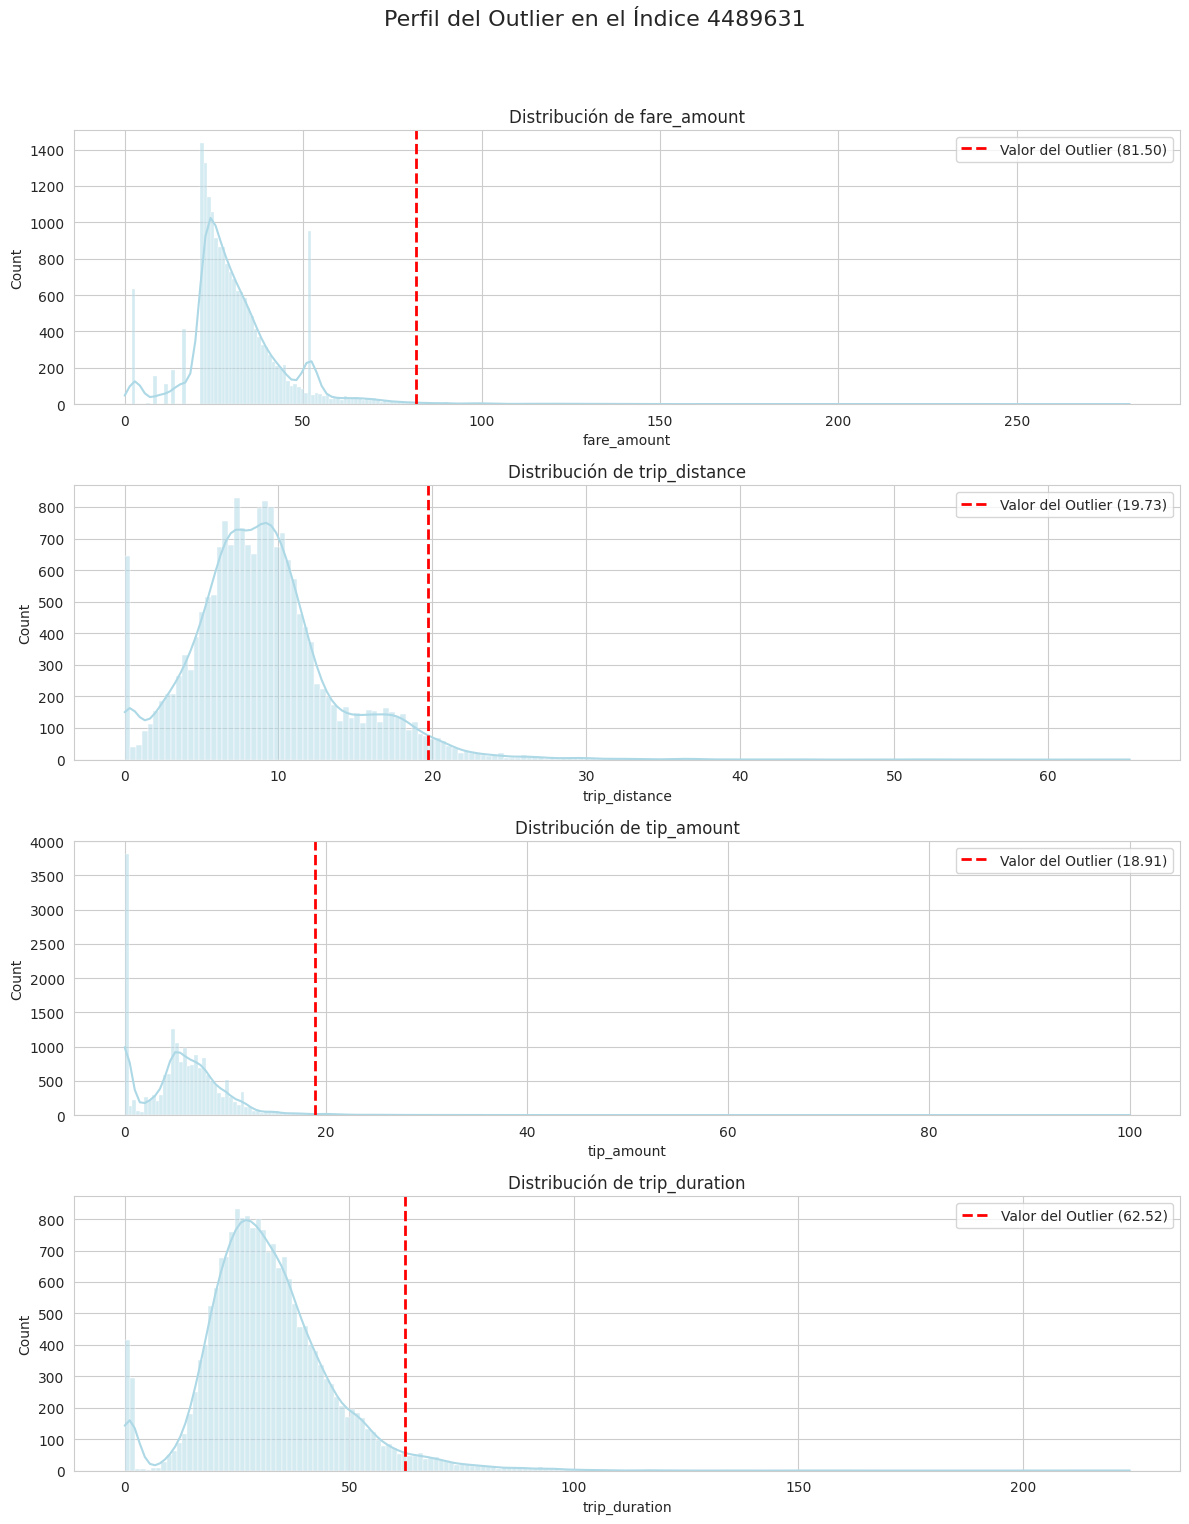

In [49]:
def perfilar_outlier_extremo(df):
    """
    Elige una observación detectada como outlier por al menos 3 técnicas y la perfila.
    """
    # Reutilizamos la lógica del paso 3 para generar la matriz de outliers
    variables = ['fare_amount', 'trip_distance', 'tip_amount', 'trip_duration']
    df_numeric = df[variables].copy()
    df_numeric['tip_amount'].fillna(0, inplace=True)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_numeric)

    outliers_df = pd.DataFrame(index=df_numeric.index)
    z_scores = np.abs(scaler.fit_transform(df_numeric))
    outliers_df['Z-score'] = (z_scores > 3).any(axis=1)
    Q1 = df_numeric.quantile(0.25); Q3 = df_numeric.quantile(0.75); IQR = Q3 - Q1
    outliers_df['IQR'] = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
    iso_forest = IsolationForest(contamination=0.02, random_state=42)
    outliers_df['Isolation Forest'] = iso_forest.fit_predict(df_scaled) == -1
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
    outliers_df['LOF'] = lof.fit_predict(df_scaled) == -1
    dbscan = DBSCAN(eps=1.5, min_samples=20)
    outliers_df['DBSCAN'] = dbscan.fit_predict(df_scaled) == -1

    # 1. Identificar un outlier común
    outliers_df['conteo_outlier'] = outliers_df.sum(axis=1)
    outliers_extremos = outliers_df[outliers_df['conteo_outlier'] >= 3]

    if outliers_extremos.empty:
        print("No se encontró ningún outlier detectado por al menos 3 técnicas en la muestra.")
        return

    # Elegimos el primer outlier extremo encontrado
    idx_a_perfilar = outliers_extremos.index[0]
    outlier_data = df.loc[idx_a_perfilar]
    print(f"Perfilando el outlier en el índice: {idx_a_perfilar}")
    print("Datos del viaje outlier:")
    print(outlier_data[variables])

    # 2. Graficar su posición relativa
    fig, axes = plt.subplots(len(variables), 1, figsize=(12, len(variables) * 4))
    fig.suptitle(f'Perfil del Outlier en el Índice {idx_a_perfilar}', fontsize=16)

    for i, var in enumerate(variables):
        sns.histplot(df[var], ax=axes[i], kde=True, color='lightblue')
        axes[i].axvline(outlier_data[var], color='red', linestyle='--', linewidth=2, label=f'Valor del Outlier ({outlier_data[var]:.2f})')
        axes[i].set_title(f'Distribución de {var}')
        axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

perfilar_outlier_extremo(df_sample.copy())

---

# Gracias por completar este laboratorio!

---
